<a href="https://colab.research.google.com/github/cosminconstantincostea/RL_cosmincostea/blob/Reinforcement-Learning/v1_0_0_SAC_Baseline_vs_PPO_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
the main goal fo this file is to chek the difference between the two learning apporaches of a SAC agent with StableBaselines3 library and comparing them with respect to a baseline.

Environment used: CityLearn.
Goal: Minimize electricty consumption.



# Common

# Google Drive Connection

In [3]:
from google.colab import drive
from datetime import datetime

drive.mount('/content/drive')



Mounted at /content/drive


## Libraries and General Parameters

In [4]:
# TODO: update to install stable version from PyPi
!pip install --no-deps CityLearn==2.2b0
!pip install nrel-pysam

# Prove standard RL algorithms
!pip install stable-baselines3


# --- Library import ---
!pip install lz4
!pip install -U ray


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 10.5 MB/s eta 0:00:00


In [5]:
# import the necessary pacakages

import gymnasium as gym
from gymnasium import spaces

import ray
from ray.tune.registry import register_env
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.algorithms.algorithm import Algorithm

# system operations
import inspect
import os
import uuid
import warnings

# date and time
import datetime

# type hinting
from typing import Any

# User interaction
from ipywidgets import Button, HTML
from ipywidgets import Text, HBox, VBox

# data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

# data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# cityLearn
from citylearn.agents.base import (
    BaselineAgent,
    Agent as RandomAgent
)
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import (
    NormalizedObservationWrapper,
    StableBaselines3Wrapper,
    TabularQLearningWrapper,
    DiscreteObservationWrapper,
    DiscreteActionWrapper
)

# RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3 import DDPG


# Callbacks
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from stable_baselines3.common.callbacks import BaseCallback

import time

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
# Global settings for the remainder of the note book

# All plotted figures without margins
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.xmargin'] = 0
%matplotlib inline

# ignore depractino warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Dataset Initialization

Load the available data within the CityLean environment and display it.

In [7]:
display('All CityLearn datasets:', sorted(DataSet.get_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_1'

schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']

'All CityLearn datasets:'

['baeda_3dem',
 'ca_alameda_county_neighborhood',
 'citylearn_challenge_2020_climate_zone_1',
 'citylearn_challenge_2020_climate_zone_2',
 'citylearn_challenge_2020_climate_zone_3',
 'citylearn_challenge_2020_climate_zone_4',
 'citylearn_challenge_2021',
 'citylearn_challenge_2022_phase_1',
 'citylearn_challenge_2022_phase_2',
 'citylearn_challenge_2022_phase_3',
 'citylearn_challenge_2022_phase_all',
 'citylearn_challenge_2023_phase_1',
 'citylearn_challenge_2023_phase_2_local_evaluation',
 'citylearn_challenge_2023_phase_2_online_evaluation_1',
 'citylearn_challenge_2023_phase_2_online_evaluation_2',
 'citylearn_challenge_2023_phase_2_online_evaluation_3',
 'citylearn_challenge_2023_phase_3_1',
 'citylearn_challenge_2023_phase_3_2',
 'citylearn_challenge_2023_phase_3_3',
 'tx_travis_county_neighborhood',
 'vt_chittenden_county_neighborhood']

### Environment Description
### Environment
<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/environment.jpg?raw=true"  width="800" alt="An overview of the heating, ventilation and air conditioning systems, energy storage systems, on-site electricity sources and grid interaction in buildings in the CityLearn environment." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: CityLearn building model including electricity sources that power controllable DERs including electric devices and ESSs, used to satisfy thermal and electrical loads as well as provide the grid with energy flexibility. A distinction is made between environment and control aspects of a building to show the transfer of actions from the control agent and reception of measurable observations by the control agent that quantifies the building's states (<a href="https://doi.org/10.48550/arXiv.2405.03848">Nweye et al., 2024</a>).</figcaption>
</figure>

CityLearn models a district of buildings with similar or different loads, electric devices, energy storage systems (ESSs) and electricity sources that satisfy the loads as shown in the figure above. There is no upper limit on the number of buildings in a district and a district can have as few as one building.

There are up to five loads ina building including:
- space cooling;
- space heating;
- domestic hot water (DHW) - all the hot water that a home needs;
- electric equipment - all the non-shiftable plug loads (lighting, entertainement, kitchen etc.);
- electric (EV) loads-

Building is modeled as single thermal zone where space thermal loads affect its indoor dry-bulb temperature. An occupant model has the ability to override the temperature setpoint.

Not all loads need to exist in a building.
Anyone or all of the loads are either known a priorii from building energy performance simulations (BEPS) or real-world measurements. In this instances the ideal load must be satisfied.
Alternatively, they are controlled loads and are inferred at runtime e.g., heat pump power control drives space cooling or heating loads.

To satisfy these loads in either the ideal or control-action case, CityLearn makes use of heating ventilation and air conditioning (HVAC) systems directly or ESSs through load shifting.
- The `cooling_device`, `heating_device`, and `dhw_device` are HVAC electric device objects in CityLearn that are used to satisfy the space cooling, space heating and DHW heating loads respectively.
- The `cooling_device` is a heat pump while the `heating_device` and `dhw_device` are either heat pump or electric heater type. These HVAC systems may be used to charge thermal energy storage (TES) systems in the building.


There are up to five optional and controlled ESSs in a building including:
TES Storages, DER type:
- `cooling_storage`;
- `heating_storage`;
- `dhw_storage`;

BESS - Battery energy storage system, DER type
- `electrical_storage`
- `electric_vehicle` - available on scheduel defined by its arrival and departure. The EV can be used in three modes:
  - G2V: Grid-to-Vehicle;
  - V2G: Vehicle-to-Grid;
  - No control: EV acts as load without any possibile control over its charging;

The electric devices are primarily powered by the electric grid. CityLearn at the time of writing, does not include a grid model so the power a building is able to draw from the grid at a given time step is unconstrained, except in the
case of a power outage.

Optionally, a building may have a photovoltaic (PV) system that provides self-generation as a first source of electricity before the grid. The optional `electrical_storage` and `electric_vehicle` are charged by the grid and PV but also augment the electricity supply when in discharge mode to supply the building with electricity. Excess self-generation, `electrical_storage`, and `electric_vehicle` discharge are sent to the grid as part of the building's net export.




### Control Variables
<table>
    <tr>
        <th>Name</th>
        <th><code>a</code> range</th>
        <th>Description</th>
    </tr>
    <tr>
        <td colspan="3"><strong>Energy storage system</strong></td>
    </tr>
    <tr>
        <td><code>cooling_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>cooling_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>heating_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>heating_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>dhw_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>dhw_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>electrical_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>electrical_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>electric_vehicle_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>electric_vehicle_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td colspan="3"><strong>Electric device</strong></td>
    </tr>
    <tr>
        <td><code>cooling_device</code></td>
        <td>[0, 1]</td>
        <td>Proportion of space <code>cooling_device</code> nominal power to be supplied.</td>
    </tr>
    <tr>
        <td><code>heating_device</code></td>
        <td>[0, 1]</td>
        <td>Proportion of space <code>heating_device</code> nominal power to be supplied.</td>
    </tr>
</table>

The table above summarizes the continuous control action space in CityLearn where there are five ESS-related actions controlling the proportion of storage capacity to be charged or discharged and two HVAC electric device actions controlling the proportion of nominal power to be supplied. There are as many `electric_vehicle_storage` actions as there are EV chargers in a building.


<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/gymnasium_interface.jpg?raw=true"  width="200" alt="Farama Foundation Gymnasium interface." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: Farama Foundation Gymnasium interface (<a href="https://zenodo.org/records/10655021">Towers et al., 2023</a>).</figcaption>
</figure>

The CityLearn environment makes use of the Farama Foundation Gymnasium interface for standardized RLC environment design, where there is an observation-action-reward exchange loop between the environment and control agent as the environment transitions from one time step to another. In the current time step, $t$, the control agent receives the environment's observations, $o_t$ and prescribes actions $a_t$. The actions are applied to the environment to affect the observations at the next time step, $o_{t + 1}$. $o_{t + 1}$ and a reward, $r_{t + 1}$ (from reward function, $R$) that quantifies the quality of $a_t$ in optimizing the outcome of a control objective or KPI are returned to the control agent to teach it to learn a control policy, $\pi$. $\pi$ maps actions to observations that maximize the
cumulative reward over an episode i.e., the terminal state of the environment, after initialization ($t = 0$), beyond which there are new observations.

<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/control_architecture.jpg?raw=true"  width="600" alt="Single-agent (left), independent multi-agent (middle), and coordinated multi-agent (right) control configurations." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: Single-agent (left), independent multi-agent (middle), and coordinated multi-agent (right) control configurations (<a href="https://doi.org/10.48550/arXiv.2405.03848">Nweye et al., 2024</a>).</figcaption>
</figure>

There are three possible control configurations in CityLearn namely:
- **single-agent** - one-to-many relationship between the control agent and buildings where a centralized agent collects observations and prescribes actions for all DERs in the district and, receives a single reward value each time step to learn a generalized control policy. Akin to an energy aggregator.
- **independent multi-agent** - configuration has a one-to-one agent-building relationship thus, there are as many rewards as buildings each time step and a unique control policy is learned for each building. The coordinated multi-agent configuration is similar to the independent multi-agent configuration except that agents can share information to achieve cooperative objectives e.g. district peak reduction or competitive objectives e.g. price bidding in the energy flexibility market.
- **coordinated multi-agent**.

### Preview of the data

In [8]:
# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.0
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.0
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.0
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.0
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.0


In [9]:
display(building_data)

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.000000
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.000000
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.000000
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.000000
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,7,19,1,0,NaN,NaN,NaN,1.346883,0.0,0.0,0.0,8.004167
8756,7,20,1,0,NaN,NaN,NaN,2.566167,0.0,0.0,0.0,0.000000
8757,7,21,1,0,NaN,NaN,NaN,3.151700,0.0,0.0,0.0,0.000000
8758,7,22,1,0,NaN,NaN,NaN,3.021500,0.0,0.0,0.0,0.000000


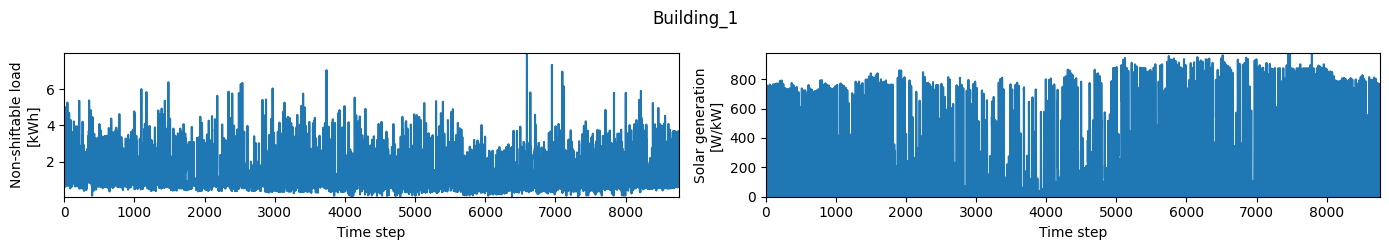

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 2.5))
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation']
axs[0].plot(x, y1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Non-shiftable load\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Solar generation\n[W/kW]')
fig.suptitle(building_name)
plt.tight_layout()
plt.show()

Preview of the weather file


In [11]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())


,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


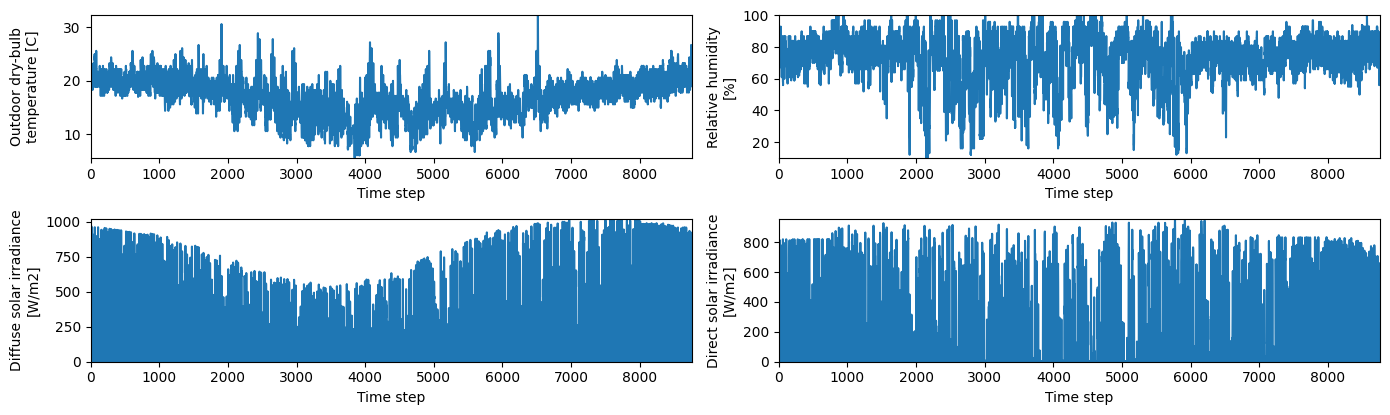

In [12]:
columns = [
    'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity',
    'diffuse_solar_irradiance', 'direct_solar_irradiance'
]
titles = [
    'Outdoor dry-bulb\ntemperature [C]', 'Relative humidity\n[%]',
    'Diffuse solar irradiance\n[W/m2]', 'Direct solar irradiance\n[W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(14, 4.25))
x = weather_data.index

for ax, c, t in zip(fig.axes, columns, titles):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(t)

fig.align_ylabels()
plt.tight_layout()
plt.show()

Preview of electricty price data

In [13]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


### Random seed for reproducibility

In [14]:
RANDOM_SEED=42

## Data Preprocessing

Te main scope of this section to build functions for:
- Bulding selection subset from the main set;
- Simulation period selection from the main set;
- Observation to use in the simulations;
- Selection of the KPIs for the evaluation.


### Number of Building - Selection Function
Scope: choose between the available buildings in the data set. Only the defined number of buildings will be used to improve training speed and model evaluation. Building 12 and Building 15 will be excluded by default.

In [15]:
def select_buildings(
dataset_name: str, count: int, seed: int, buildings_to_exclude: list[str] = None,
) -> list[str]:
    """ Randoms elect buildings from Citylearn dataset.

    Parameters
    ----------
    dataset_name = str
        CityLearn dataset to query buildings from.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator
    building_to_exclude: list[str]
        List of buildings to exclude from selection pool

    Returns
    -------
    buildings: list[str]
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15'

    # set random seed
    np.random.seed(seed)

    # get all bulding names
    schema = DataSet.get_schema(dataset_name)
    buildings = list(schema['buildings'].keys())

    # remove buildings 12 and 15 as they have peculiarities in thei data
    # that are no relevant for this application
    buildings_to_exclude = [] if buildings_to_exclude is None \
        else [b for b in buildings_to_exclude]
    buildings_to_exclude += ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        if b in buildings:
            buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, count, replace=False)

    return buildings.tolist()

### Simulation Period - Selection Function
Scope:
- Select a training period within the main dataset to train the agent;
- Select a testing period within the main dataset to test the agent on;

Currently the data is split in 70% training - 30% testing.



In [16]:
def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    # Split for testing and training
    # 70% testing
    # 30% training
    training_days = int(count*0.7)
    print("Training days:", training_days)
    testing_days = int(count*0.3)
    print("Testing days:", testing_days)

    training_time_steps = training_days*24
    print("Training time steps:", training_time_steps)
    testing_time_steps = testing_days*24
    print("Testing time steps:", testing_time_steps)

    training_start_time_step = simulation_start_time_step
    training_end_time_step   = simulation_start_time_step + training_time_steps -1

    testing_start_time_step = training_end_time_step + 1
    testing_end_time_step   = testing_start_time_step + testing_time_steps -1

    return simulation_start_time_step, simulation_end_time_step,\
           training_start_time_step, training_end_time_step, \
           testing_start_time_step , testing_end_time_step



## Get KPIs for evaluations
n.5 KPIs are considered to measure how good the agent is performing:
1. electricity cost;
2. carbon emissions;
3. average daily peak;
4. ramping;
5. 1-load factor;

3 and 5 are District level KPIs


### Convenience functions to display simulation results
In the following some convenience function will be defined to plot the simulation results to confront different agents behaviour.


In [17]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """
    kpis = env.unwrapped.evaluate()

    """try:
        kpis = env.unwrapped.evaluate()
    except ZeroDivisionError:
        # Skip or insert a dummy KPI table
        kpis = pd.DataFrame(columns=['cost_function', 'value', 'level', 'name'])
    """

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 2 decimal places for readability
    kpis['value'] = kpis['value'].round(2)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    # Add epsilon to prevent division by zero in 1 - load factor calculation
    epsilon = 1e-9
    kpis.loc[kpis['kpi'] == '1 - load factor', 'value'] = kpis.loc[kpis['kpi'] == '1 - load factor', 'value'].apply(lambda x: x if x != 0 else epsilon)


    return kpis

#### Normalize KPIs to reference

In [18]:
def normalize_kpis_to_reference(kpis: pd.DataFrame, reference_env_id: str) -> pd.DataFrame:
    """
    Normalize KPI values relative to a reference environment.

    The reference environment's KPI values become 1.0, and all others
    are divided by those baseline values.

    Parameters
    ----------
    kpis : pd.DataFrame
        Combined KPI table containing multiple env_ids.
        Must include columns ['env_id', 'kpi', 'name', 'value'].
        (For district-level KPIs, 'name' can be missing or NaN — handled automatically.)
    reference_env_id : str
        Environment ID to use as baseline for normalization.

    Returns
    -------
    pd.DataFrame
        Same KPI table with normalized 'value' column.
    """
    import pandas as pd

    # Copy to avoid mutating the input DataFrame
    kpis = kpis.copy()

    # Build a baseline lookup: (kpi, name) → value
    baseline = kpis[kpis['env_id'] == reference_env_id].copy()
    if 'name' not in baseline.columns:
        baseline['name'] = None  # for district-level where name may be missing

    baseline_lookup = baseline.set_index(['kpi', 'name'])['value']

    # Define a function for normalization lookup
    def normalize_row(row):
        key = (row['kpi'], row.get('name', None))
        base_val = baseline_lookup.get(key, None)
        if base_val is not None and base_val != 0:
            return row['value'] / base_val
        else:
            return row['value']  # leave unchanged if no baseline or zero baseline

    # Apply normalization
    kpis['value'] = kpis.apply(normalize_row, axis=1)

    return kpis


#### Plot - Building KPI

In [19]:
def plot_building_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)

    reference_env_id = list(envs.keys())[0]  # first env as baseline
    kpis = normalize_kpis_to_reference(kpis, reference_env_id)

    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        for j, _ in enumerate(envs):
            ax.bar_label(ax.containers[j], fmt='%.2f')

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    return fig

#### Plot - Disctrict KPI

In [20]:
def plot_district_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)

    reference_env_id = list(envs.keys())[0]  # first env as baseline
    kpis = normalize_kpis_to_reference(kpis, reference_env_id)

    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for j, _ in enumerate(envs):
        ax.bar_label(ax.containers[j], fmt='%.2f')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

#### Plot - Building Load Profile

In [21]:
def plot_building_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.unwrapped.buildings[i].net_electricity_consumption
            y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_ylabel('kWh')

        if daily_average:
            ax.set_xlabel('Hour')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

        else:
            ax.set_xlabel('Time step')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [22]:
def plot_average_building_load_profiles(
    envs: dict[str, CityLearnEnv], mode: str = "raw"
) -> plt.Figure:
    """
    Plot building-level net electricity consumption profiles.

    For 'weekly' or 'monthly' mode:
    - Compute average profile for each week/month sequentially
      and plot their evolution across the year.
    """

    # --- setup subplot grid ---
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count / column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0 * column_count, 1.75 * row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            if i >= len(v.buildings):
                continue

            y = np.array(v.buildings[i].net_electricity_consumption)

            # --- mode-specific handling ---
            if mode == "daily":
                period = 24
                y_trim = y[: (len(y) // period) * period]
                y = np.reshape(y_trim, (-1, period)).mean(axis=0)
                x = np.arange(24)
                ax.set_xlabel("Hour of Day")

            elif mode == "weekly":
                period = 24 * 7
                y_trim = y[: (len(y) // period) * period]
                y_weeks = np.reshape(y_trim, (-1, period))
                weekly_means = np.mean(y_weeks, axis=1)  # one avg per week
                y = weekly_means
                x = np.arange(len(y))
                ax.set_xlabel("Week of Year")

            elif mode == "monthly":
                period = 24 * 30
                y_trim = y[: (len(y) // period) * period]
                y_months = np.reshape(y_trim, (-1, period))
                monthly_means = np.mean(y_months, axis=1)  # one avg per month
                y = monthly_means
                x = np.arange(len(y))
                ax.set_xlabel("Month of Year")

            else:  # raw
                x = np.arange(len(y))
                ax.set_xlabel("Time step")

            ax.plot(x, y, label=k)

        ax.set_title(v.buildings[i].name)
        ax.set_ylabel("kWh")

        if i == building_count - 1:
            ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    return fig


#### Plot - Distric Load Profile

In [23]:
def plot_district_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.unwrapped.net_electricity_consumption
        y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_ylabel('kWh')

    if daily_average:
        ax.set_xlabel('Hour')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    else:
        ax.set_xlabel('Time step')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

In [24]:
def plot_average_district_load_profiles(
    envs: dict[str, CityLearnEnv], mode: str = "raw"
) -> plt.Figure:
    """
    Plot district-level net electricity consumption profiles.

    For 'weekly' or 'monthly' mode:
    - Compute average district load for each week/month sequentially
      and plot its evolution across the year.

    Parameters
    ----------
    envs : dict[str, CityLearnEnv]
        Mapping of agent names to CityLearn environments.
    mode : str, default "raw"
        One of {"raw", "daily", "weekly", "monthly"}:
        - "raw": full time series
        - "daily": average daily profile (24 hours)
        - "weekly": sequential weekly averages
        - "monthly": sequential monthly averages

    Returns
    -------
    fig : plt.Figure
        Figure containing plotted axes.
    """
    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = np.array(v.net_electricity_consumption)

        # --- mode-specific processing ---
        if mode == "daily":
            period = 24
            y_trim = y[: (len(y) // period) * period]
            y = np.reshape(y_trim, (-1, period)).mean(axis=0)
            x = np.arange(24)
            ax.set_xlabel("Hour of Day")

        elif mode == "weekly":
            period = 24 * 7
            y_trim = y[: (len(y) // period) * period]
            y_weeks = np.reshape(y_trim, (-1, period))
            weekly_means = np.mean(y_weeks, axis=1)
            y = weekly_means
            x = np.arange(len(y))
            ax.set_xlabel("Week of Year")

        elif mode == "monthly":
            period = 24 * 30
            y_trim = y[: (len(y) // period) * period]
            y_months = np.reshape(y_trim, (-1, period))
            monthly_means = np.mean(y_months, axis=1)
            y = monthly_means
            x = np.arange(len(y))
            ax.set_xlabel("Month of Year")

        else:  # raw
            x = np.arange(len(y))
            ax.set_xlabel("Time step")

        ax.plot(x, y, label=k)

    ax.set_ylabel("kWh")

    if mode == "daily":
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    elif mode == "weekly":
        ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    elif mode == "monthly":
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    else:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24 * 7))

    ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    plt.tight_layout()
    return fig
#

#### Plot - SOC profiles


In [25]:
def plot_battery_soc_profiles(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = np.array(v.unwrapped.buildings[i].electrical_storage.soc)
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
        ax.set_ylim(0.0, 1.0)

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [26]:
def plot_average_soc_profiles(
    envs: dict[str, CityLearnEnv], mode: str = "raw"
) -> plt.Figure:
    """
    Plot building-level battery state of charge (SOC) profiles.

    For 'weekly' or 'monthly' mode:
    - Compute average SOC for each week/month sequentially
      and plot their evolution across the year.
    """

    # --- setup subplot grid ---
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count / column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0 * column_count, 1.75 * row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            if i >= len(v.buildings):
                continue

            # --- get SOC time series ---
            y = np.array(v.buildings[i].electrical_storage.soc)

            # --- mode-specific handling ---
            if mode == "daily":
                period = 24
                y_trim = y[: (len(y) // period) * period]
                y = np.reshape(y_trim, (-1, period)).mean(axis=0)
                x = np.arange(24)
                ax.set_xlabel("Hour of Day")

            elif mode == "weekly":
                period = 24 * 7
                y_trim = y[: (len(y) // period) * period]
                y_weeks = np.reshape(y_trim, (-1, period))
                weekly_means = np.mean(y_weeks, axis=1)
                y = weekly_means
                x = np.arange(len(y))
                ax.set_xlabel("Week of Year")

            elif mode == "monthly":
                period = 24 * 30
                y_trim = y[: (len(y) // period) * period]
                y_months = np.reshape(y_trim, (-1, period))
                monthly_means = np.mean(y_months, axis=1)
                y = monthly_means
                x = np.arange(len(y))
                ax.set_xlabel("Month of Year")

            else:  # raw
                x = np.arange(len(y))
                ax.set_xlabel("Time step")

            ax.plot(x, y, label=k)

        ax.set_title(v.buildings[i].name)
        ax.set_ylabel("State of Charge (SOC)")

        if i == building_count - 1:
            ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    return fig


#### Plot - Simulation Summary

In [27]:
def plot_simulation_summary(envs: dict[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    print('#'*8 + ' BUILDING-LEVEL ' + '#'*8)
    print('Building-level KPIs:')
    _ = plot_building_kpis(envs)
    plt.show()

    print('Building-level simulation period load profiles:')
    _ = plot_building_load_profiles(envs)
    plt.show()

    print('Building-level daily-average load profiles:')
    _ = plot_building_load_profiles(envs, daily_average=True)
    plt.show()

    print('Battery SoC profiles:')
    _ = plot_battery_soc_profiles(envs)
    plt.show()

    print('#'*8 + ' DISTRICT-LEVEL ' + '#'*8)
    print('District-level KPIs:')
    _ = plot_district_kpis(envs)
    plt.show()

    print('District-level simulation period load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

    print('District-level daily-average load profiles:')
    _ = plot_district_load_profiles(envs, daily_average=True)
    plt.show()

#### Plot - Actions

In [28]:
def plot_actions(actions_list: list[list[float]], building_names: list[str], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: list[list[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    building_names: list[str]:
        List of build names that map to the action lists.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    plot_data = pd.DataFrame(actions_list, columns=building_names)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
    ax.set_title(title)

    return fig

In [101]:
def plot_average_actions(
    actions_list: list[list[float]],
    building_names: list[str],
    title: str,
    mode: str = "daily_mean"
) -> plt.Figure:
    """
    Plot averaged action time series for different buildings.

    For 'daily_mean', 'weekly', or 'monthly' mode:
    - 'daily_mean': Compute the average daily action pattern (mean of all days)
    - 'weekly'/'monthly': Compute sequential averages per week/month and plot them

    Parameters
    ----------
    actions_list : list[list[float]]
        Each element (index i) represents actions for all buildings at time step i.
    building_names : list[str]
        List of building names corresponding to columns.
    title : str
        Plot title.
    mode : str, default "daily_mean"
        One of {"raw", "daily_mean", "weekly", "monthly"}.

    Returns
    -------
    fig : plt.Figure
        Figure containing the plotted data.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib import ticker

    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    plot_data = pd.DataFrame(actions_list, columns=building_names)

    # --- choose period based on mode ---
    if mode in ["daily", "daily_mean"]:
        period = 24
    elif mode == "weekly":
        period = 24 * 7
    elif mode == "monthly":
        period = 24 * 30
    else:
        period = None

    for c in plot_data.columns:
        y = np.array(plot_data[c].tolist())

        if period is not None:
            y = y[: (len(y) // period) * period]  # trim incomplete block
            y_blocks = np.reshape(y, (-1, period))

            if mode == "daily_mean":
                # Average over all days (mean hourly pattern)
                y = np.mean(y_blocks, axis=0)
                x = np.arange(period)
            elif mode in ["weekly", "monthly"]:
                # Average sequentially per week/month
                y = np.mean(y_blocks, axis=1)
                x = np.arange(len(y))
            else:
                # Just show first day if "daily"
                y = y_blocks[0]
                x = np.arange(period)
        else:
            # Raw mode
            x = np.arange(len(y))

        ax.plot(x, y, label=c)

    # --- set axis labels and ticks ---
    if mode == "daily_mean":
        ax.set_xlabel("Hour of Day")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    elif mode == "weekly":
        ax.set_xlabel("Week of Year")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    elif mode == "monthly":
        ax.set_xlabel("Month of Year")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    else:
        ax.set_xlabel("Time step")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24 * 7))

    ax.set_ylabel(r"$\frac{kWh}{kWh_{capacity}}$")
    ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_title(title)
    plt.tight_layout()

    return fig


#### Plot - Rewards




In [30]:
def plot_rewards(ax: plt.Axes, rewards: list[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: list[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

#### Plot Average Epoch Reward

In [31]:
def plot_aer(agent_rewards_dict, epochs, episodes_per_epoch):
    """
    Plots the Average Epoch Rewards (AER) for multiple agents.

    Parameters
    ----------
    agent_rewards_dict : dict
        Dictionary where keys are agent names (str) and values are lists of episode rewards (from ARC.get_rewards()).
        Example:
            {
                "DQN": rewards_dqn,
                "PPO": rewards_ppo,
                "SAC": rewards_sac
            }

    epochs : int
        Total number of epochs to consider.

    episodes_per_epoch : int
        Number of episodes in each epoch.

    Returns
    -------
    None
        Displays a matplotlib plot of all agents' AER curves.
    """
    plt.figure(figsize=(10, 6))

    for agent_name, episode_rewards in (agent_rewards_dict.items()):
        aer_values = average_epoch_reward(episode_rewards, epochs, episodes_per_epoch)
        plt.plot(range(1, len(aer_values) + 1), aer_values, label=agent_name)

    plt.xlabel("Epoch")
    plt.ylabel("Average Reward per Epoch")
    plt.title("Average Epoch Rewards of Agents")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## SAC Simulation

### Custom Reward Definiton


#### Base case reward
The goal is to reduce the electricty price paid for the energy

In [32]:
class CustomReward(RewardFunction):
    def __init__(self, env_metadata: dict[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: dict[str, Any]:
            General static information about the environment.
        """

        super().__init__(env_metadata)

    def calculate(
        self, observations: list[dict[str, int | float]]
    ) -> list[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """

        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_soc = o['electrical_storage_soc']
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)
            reward_list.append(reward)

        reward = [sum(reward_list)]

        return reward

### Callback function to monitor the training phase

#### Callback Calls

In [33]:
def average_epoch_reward(episode_rewards, epochs, episodes):
    """Compute average reward per epoch, truncating any extra episodes.

    Args:
        episode_rewards (list[float]): total reward per episode.
        epochs (int): number of epochs expected.
        episodes (int): number of episodes per epoch.

    Returns:
        list[float]: average reward for each epoch.
    """
    expected = epochs * episodes

    # Cut off extra rewards if too many
    if len(episode_rewards) > expected:
        print(f"Truncating {len(episode_rewards) - expected} extra episodes.")
        episode_rewards = episode_rewards[:expected]

    # Pad with zeros if fewer rewards than expected
    if len(episode_rewards) < expected:
        print(f"Missing {expected - len(episode_rewards)} episodes, padding with 0.")
        episode_rewards = episode_rewards + [0] * (expected - len(episode_rewards))

    averages = []
    for ii in range(0, expected, episodes):
        chunk = episode_rewards[ii:ii+episodes]
        averages.append(sum(chunk) / len(chunk))
    return averages


In [34]:
class AverageRewardCallback(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []   # Stores total reward per episode
        self.relative_rewards = []
        self.current_reward = 0
        self.min_reward = None
        self.epsilon = 1e-6

    def _on_step(self) -> bool:
        # Accumulate rewards for the current episode
        self.current_reward += self.locals["rewards"][0]

        # When episode ends
        if self.locals["dones"][0]:
          abs_reward = self.current_reward

          # Track worst reward
          if self.min_reward is None:
            self.min_reward = abs_reward
          self.min_reward = min(self.min_reward, abs_reward)

          #Normalzie into [-1,0]
          rel_reward = abs_reward / (abs(self.min_reward) + self.epsilon)

          self.episode_rewards.append(abs_reward)
          self.relative_rewards.append(rel_reward)

          avg_rel = np.mean(self.relative_rewards)
          avr_reward = np.mean(self.episode_rewards)

          if self.verbose > 0:
              print(f"Episode {len(self.episode_rewards)} | "
                    f"Abs Reward: {self.current_reward:.2f} | "
                    f"Avg Reward: {avg_reward:.2f} |"
                    f"Rel Reward: {avg_rel:2.f}")

          self.current_reward = 0  # reset for next episode

        return True

    def _on_training_end(self):
        if self.verbose > 0:
            print(f"\nTraining complete. Final Average Reward: {np.mean(self.episode_rewards):.2f}")

    def get_rewards(self):
        """Returns the list of episode rewards."""
        return self.episode_rewards
    def get_relative_rewards(self):
        """Return the list of episode realive rewards"""
        return self.relative_rewards


### Pipeline Class

In [35]:
# Function to help saving the data from the training.

def to_serializable(obj):
        """Recursively convert NumPy types to native Python types for JSON saving."""
        if isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [to_serializable(v) for v in obj]
        else:
            return obj

In [36]:
class TrainTestModel:
    def __init__(self, TRAIN_DATASET_NAME, TEST_DATASET_NAME, AGENT_TYPE, ACTIVE_OBSERVATIONS,
                 TRAIN_START_TIME_STEP, TRAIN_END_TIME_STEP,
                 TEST_START_TIME_STEP, TEST_END_TIME_STEP, EPISODE_TIME_STEPS,
                 CUSTOM_REWARD, RANDOM_SEED, CALLBACK, EPOCHS, BUILDING_COUNT, verbose=0):



        # --- Store parameters ---
        self.train_dataset_name = TRAIN_DATASET_NAME
        self.test_dataset_name = TEST_DATASET_NAME
        self.agent_type = AGENT_TYPE
        self.active_observations = ACTIVE_OBSERVATIONS
        self.train_start_time_step = TRAIN_START_TIME_STEP
        self.train_end_time_step = TRAIN_END_TIME_STEP
        self.test_start_time_step = TEST_START_TIME_STEP
        self.test_end_time_step = TEST_END_TIME_STEP
        self.episode_time_steps = EPISODE_TIME_STEPS
        self.custom_reward = CUSTOM_REWARD
        self.random_seed = RANDOM_SEED
        self.callback_model = CALLBACK
        self.epochs = EPOCHS
        self.verbose = verbose




        # --- Building selection ---
        self.building_count = BUILDING_COUNT
        self.TRAIN_BUILDINGS = select_buildings(
            TRAIN_DATASET_NAME,
            self.building_count,
            self.random_seed
        )
        self.TEST_BUILDINGS = select_buildings(
            TEST_DATASET_NAME,
            self.building_count,
            self.random_seed
        )

        self.total_train_timesteps = TRAIN_END_TIME_STEP - TRAIN_START_TIME_STEP + 1
        self.total_episodes = self.total_train_timesteps/EPISODE_TIME_STEPS

        self.total_test_timesteps = TEST_END_TIME_STEP - TEST_START_TIME_STEP + 1

        # --- CityLearn Env creation ---
        self.train_env = CityLearnEnv(
            TRAIN_DATASET_NAME,
            central_agent=self.agent_type,
            buildings=self.TRAIN_BUILDINGS,
            #active_observations=ACTIVE_OBSERVATIONS,
            simulation_start_time_step=TRAIN_START_TIME_STEP,
            simulation_end_time_step=TRAIN_END_TIME_STEP,
            reward_function=CUSTOM_REWARD,
            episode_time_steps=EPISODE_TIME_STEPS,
        )
        # Healthy check for the environment
        from pprint import pprint
        observations, _ = self.train_env.reset()
        obs = observations
        obs_names = self.train_env.observation_names
        train_obs_dict = dict(zip(obs_names[0], obs[0]))
        print('Observation Dictionary for Training Env')
        pprint(train_obs_dict)

        self.test_env = CityLearnEnv(
            TEST_DATASET_NAME,
            central_agent=self.agent_type,
            buildings=self.TEST_BUILDINGS,
            #active_observations=ACTIVE_OBSERVATIONS,
            simulation_start_time_step=TEST_START_TIME_STEP,
            simulation_end_time_step=TEST_END_TIME_STEP,
            reward_function=CUSTOM_REWARD,
        )

        # Healthy check for the environment
        observations, _ = self.test_env.reset()
        obs = observations
        obs_names = self.test_env.observation_names
        test_obs_dict = dict(zip(obs_names[0], obs[0]))
        print('Observation Dictionary for Testing Env')
        pprint(test_obs_dict)


        # --- Wrap the environments ---
        self.train_env = NormalizedObservationWrapper(self.train_env)
        self.train_env = StableBaselines3Wrapper(self.train_env)
        print('Train Env correctly created')
        #print('Train Env Reset:', self.train_env.reset())

        self.test_env = NormalizedObservationWrapper(self.test_env)
        self.test_env = StableBaselines3Wrapper(self.test_env)
        print('Test Env correctly created')
        #print('Test Env Reset:', self.test_env.reset())

        # --- Model Definition ---
        self.sac_model = SAC(policy='MlpPolicy', env=self.train_env, seed=self.random_seed)

    def train(self):
        """Train the SAC model and return training results."""
        start_time = time.perf_counter()

        # self.sac_model.learn(
        #     total_timesteps=self.total_train_timesteps * self.epochs,
        #     reset_num_timesteps=False,
        #     callback=self.callback_model,
        #     progress_bar=True
        # )

        for epoch in tqdm(range(self.epochs)):

          self.sac_model.learn(
              total_timesteps = self.total_train_timesteps,
              reset_num_timesteps=False,
              progress_bar = True,
              callback=self.callback_model
          )


        elapsed_training_time = time.perf_counter() - start_time
        print("Agent - Training time: ", elapsed_training_time)

        train_results = {
            "training_time": elapsed_training_time,
            "callback_relative_rewards": self.callback_model.get_relative_rewards(),
            "callback_rewards": self.callback_model.get_rewards(),
            "model": self.sac_model,
            "total_training_time_steps": self.total_train_timesteps * self.epochs,
            "episode_length": EPISODE_TIME_STEPS,
            "total_episodes": self.total_episodes
        }

        self.last_train_results = train_results

        return train_results

    def test(self):
        """Test the model and return test results."""
        observations, _ = self.test_env.reset()
        sac_action_list = []
        reward_list = []
        counter_steps = 0

        while not self.test_env.unwrapped.terminated:
            actions, _ = self.sac_model.predict(observations, deterministic=True)
            observations, reward, _, _, _ = self.test_env.step(actions)

            sac_action_list.append(actions)
            reward_list.append(reward)
            counter_steps += 1

            if counter_steps % 50 == 0 and self.verbose == 1:
                print(actions)
                print(observations)

        test_results = {
            "actions": sac_action_list,
            "rewards": reward_list,
            "steps": counter_steps,
        }

        self.counter_steps = counter_steps
        self.last_test_results = test_results

        return test_results

    import os, json, time

    import numpy as np


    def save(self, save_dir="saved_models", model_name="sac_model"):
        """Save model and training/testing results as JSON."""
        os.makedirs(save_dir, exist_ok=True)

        # --- 1. Save the model (SB3 native) ---
        model_path = os.path.join(save_dir, f"{model_name}.zip")
        self.sac_model.save(model_path)

        # --- 2. Prepare metadata/results ---
        results_to_save = {
            "metadata": {
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                "train_dataset_name": self.train_dataset_name,
                "test_dataset_name": self.test_dataset_name,
                "active_observations": self.active_observations,
                "train_start_time_step": self.train_start_time_step,
                "train_end_time_step": self.train_end_time_step,
                "test_start_time_step": self.test_start_time_step,
                "test_end_time_step": self.test_end_time_step,
                "episode_time_steps": self.episode_time_steps,
                "agent_type": self.agent_type,
                "epochs": self.epochs,
                "random_seed": self.random_seed,
                "test_buildings": self.TEST_BUILDINGS,
                "train_buildings": self.TRAIN_BUILDINGS,
            },
            "train_results": {
                "training_time": self.last_train_results.get("training_time", None),
                "mean_callback_reward": float(np.mean(self.last_train_results.get("callback_rewards", [0]))),
                "callback_absolute": self.callback_model.get_rewards(),
                "callback_relative":self.callback_model.get_relative_rewards(),
                "rewards": self.last_train_results.get("callback_rewards", []),
                "total_training_time_steps":self.total_train_timesteps*self.epochs,
                "total_episodes": self.total_episodes
            },
            "test_results": {
                "steps": self.last_test_results.get("steps", None),
                "mean_reward": float(np.mean(self.last_test_results.get("rewards", [0]))),
                "rewards": self.last_test_results.get("rewards", []),
                "actions": self.last_test_results.get("actions", [])
            }
        }
        results_to_save = to_serializable(results_to_save)
        # --- 3. Save results as JSON ---
        json_path = os.path.join(save_dir, f"{model_name}_results.json")
        with open(json_path, "w") as f:
            json.dump(results_to_save, f, indent=4, default=float)

        print(f"Model saved to {model_path}")
        print(f"Results saved to {json_path}")

    def load(load_dir="saved_models", model_name="sac_model"):
        """Reload a trained model and its metadata."""
        from stable_baselines3 import SAC


        json_path = os.path.join(load_dir, f"{model_name}_results.json")
        model_path = os.path.join(load_dir, f"{model_name}.zip")

        if not os.path.exists(json_path):
          raise FileNotFoundError(f"Could not find JSON results file at: {json_path}")
        if not os.path.exists(model_path):
          raise FileNotFoundError(f"Could not find model file at: {model_path}")

        with open(json_path, "r") as f:
          results_data = json.load(f)

        metadata = results_data["metadata"]
        train_results = results_data.get("train_results",{})
        test_results = results_data.get("test_results",{})

        TRAIN_DATASET_NAME = metadata["train_dataset_name"]
        TEST_DATASET_NAME = metadata["test_dataset_name"]
        ACTIVE_OBSERVATIONS = metadata["active_observations"]
        TRAIN_START_TIME_STEP = metadata["train_start_time_step"]
        TRAIN_END_TIME_STEP = metadata["train_end_time_step"]
        TEST_START_TIME_STEP = metadata["test_start_time_step"]
        TEST_END_TIME_STEP = metadata["test_end_time_step"]
        EPISODE_TIME_STEPS = metadata["episode_time_steps"]
        #CALLBACK_ABSOLUTE = metadata["callback_absolute"]
        #CALLBACK_RELATIVE = metadata["callback_relative"]
        AGENT_TYPE = metadata["agent_type"]
        EPOCHS = metadata["epochs"]
        RANDOM_SEED = metadata["random_seed"]
        TEST_BUILDINGS = metadata["test_buildings"]
        TRAIN_BUILDINGS = metadata["train_buildings"]

        train_env = CityLearnEnv(
            TRAIN_DATASET_NAME,
            central_agent=AGENT_TYPE,
            buildings=TRAIN_BUILDINGS,
            #active_observations=ACTIVE_OBSERVATIONS,
            simulation_start_time_step=TRAIN_START_TIME_STEP,
            simulation_end_time_step=TRAIN_END_TIME_STEP,
            reward_function=CustomReward,
            episode_time_steps=EPISODE_TIME_STEPS,
        )

        test_env = CityLearnEnv(
            TEST_DATASET_NAME,
            central_agent=AGENT_TYPE,
            buildings=TEST_BUILDINGS,
            #active_observations=ACTIVE_OBSERVATIONS,
            simulation_start_time_step=TEST_START_TIME_STEP,
            simulation_end_time_step=TEST_END_TIME_STEP,
            reward_function=CustomReward,
            episode_time_steps=EPISODE_TIME_STEPS,
        )

        train_env = NormalizedObservationWrapper(train_env)
        train_env = StableBaselines3Wrapper(train_env)
        test_env = NormalizedObservationWrapper(test_env)
        test_env = StableBaselines3Wrapper(test_env)

        # --- Load model ---
        model = SAC.load(model_path, env=train_env)

        print(f"Model loaded from {model_path}")
        print(f"Results loaded from {json_path}" if results_data else "No results file found")

        return model, results_data, train_env, test_env

### DASHBOARD CONTROL SIMULATION PARAMS


In [37]:
# Calculate the different periods for the traning time

months = [31,28,31,30,31,30,31,31,30,31,30,31]

mm=1
hour_in_months = [0]
for mm in range(len(months)-1):
  hours_start = months[mm]*24+hour_in_months[mm]
  hour_in_months.append(hours_start)


jun = 6-1
jul = 7-1
aug = 8-1

nov = 11-1
dec = 12-1
jan = 1-1

print("Starting our of each month\n", hour_in_months)
train_summer_period_start = hour_in_months[jun]
train_summer_period_end = hour_in_months[jul]+months[jul]*24-1
train_summer_days = (train_summer_period_end-train_summer_period_start+1)/24
print("\nTrain Summer period start", train_summer_period_start)
print("Train Summer period end", train_summer_period_end)
print("Train summer days", train_summer_days)

train_winter_period_start = hour_in_months[nov]
train_winter_period_end = hour_in_months[dec]+months[dec]*24-1
train_winter_days = (train_winter_period_end-train_winter_period_start+1)/24
print("\nTrain Winter period start", train_winter_period_start)
print("Train Winter period end", train_winter_period_end)
print("Train winter days", train_winter_days)

test_summer_start = hour_in_months[aug]
test_summer_end = hour_in_months[aug]+months[aug]*24-1
test_summer_days = (test_summer_end-test_summer_start+1)/24
print("\nTest Summer period start", test_summer_start)
print("Test Summer period end", test_summer_end)
print("Test summer days", test_summer_days)

test_winter_start = hour_in_months[jan]
test_winter_end = hour_in_months[jan]+months[jan]*24-1
test_winter_days = (test_winter_end-test_winter_start+1)/24
print("\nTest Winter period start", test_winter_start)
print("Test Winter period end", test_winter_end)
print("Test winter days", test_winter_days)


Starting our of each month
 [0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016]

Train Summer period start 3624
Train Summer period end 5087
Train summer days 61.0

Train Winter period start 7296
Train Winter period end 8759
Train winter days 61.0

Test Summer period start 5088
Test Summer period end 5831
Test summer days 31.0

Test Winter period start 0
Test Winter period end 743
Test winter days 31.0


In [38]:
#display('All CityLearn datasets:', sorted(DataSet.get_names()))
TRAIN_DATASET = 'citylearn_challenge_2022_phase_2'
TEST_DATASET = 'citylearn_challenge_2022_phase_3'

EPISODE_TIME_STEPS = 24; # I choose to run it over 1 day for multiple periods
EPOCHS = 20
# The control will be centralized: one agent will control al the buildings.
CENTRAL_AGENT = True

BUILDING_COUNT = 3
BUILDINGS = select_buildings(
    TRAIN_DATASET,
    BUILDING_COUNT,
    RANDOM_SEED,
)
BUILDINGS_TEST = select_buildings(
    TEST_DATASET,
    BUILDING_COUNT,
    RANDOM_SEED
)
#print('Selected building:', BUILDINGS)

ACTIVE_OBSERVATIONS = ['hour']

# Callback to monitor the base care reward
callback_base= AverageRewardCallback(verbose=0)

period = ["summer","winter"]

simulation = period[0]

if simulation == "summer":
  TRAIN_START_TIME_STEP = train_summer_period_start
  TRAIN_END_TIME_STEP = train_summer_period_end
  TEST_START_TIME_STEP = test_summer_start
  TEST_END_TIME_STEP = test_summer_end
else:
  TRAIN_START_TIME_STEP = train_winter_period_start
  TRAIN_END_TIME_STEP = train_winter_period_end
  TEST_START_TIME_STEP = test_winter_start
  TEST_END_TIME_STEP = test_winter_end

# DAY_COUNT = 365 #use it in case you want to do it for the same year.
# SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP,\
# TRAINING_START_TIME_STEP, TRAINING_END_TIME_STEP,\
# TESTING_START_TIME_STEP, TESTING_END_TIME_STEP = select_simulation_period(
#     DATASET_NAME,
#     DAY_COUNT,
#     RANDOM_SEED
# )

# Simulation end time step over 1 year
simulation_end_timestep = 8759

### Environment Creation


In [39]:
trainer_sac_baseline = TrainTestModel(
    TRAIN_DATASET_NAME = TRAIN_DATASET,
    TEST_DATASET_NAME = TEST_DATASET,
    AGENT_TYPE = CENTRAL_AGENT,
    ACTIVE_OBSERVATIONS = None,
    TRAIN_START_TIME_STEP = TRAIN_START_TIME_STEP,
    TRAIN_END_TIME_STEP = TRAIN_END_TIME_STEP,
    TEST_START_TIME_STEP = TEST_START_TIME_STEP,
    TEST_END_TIME_STEP = TEST_END_TIME_STEP,
    EPISODE_TIME_STEPS = EPISODE_TIME_STEPS,
    CUSTOM_REWARD = CustomReward,
    RANDOM_SEED = RANDOM_SEED,
    CALLBACK = callback_base,
    EPOCHS = EPOCHS,
    BUILDING_COUNT = BUILDING_COUNT,
    verbose = 0,
)

Observation Dictionary for Training Env
{'carbon_intensity': np.float32(0.20185244),
 'day_type': np.int32(4),
 'diffuse_solar_irradiance': np.float32(0.0),
 'diffuse_solar_irradiance_predicted_12h': np.float32(545.0),
 'diffuse_solar_irradiance_predicted_24h': np.float32(0.0),
 'diffuse_solar_irradiance_predicted_6h': np.float32(0.0),
 'direct_solar_irradiance': np.float32(0.0),
 'direct_solar_irradiance_predicted_12h': np.float32(841.0),
 'direct_solar_irradiance_predicted_24h': np.float32(0.0),
 'direct_solar_irradiance_predicted_6h': np.float32(0.0),
 'electrical_storage_soc': np.float32(0.0),
 'electricity_pricing': np.float32(0.21),
 'electricity_pricing_predicted_12h': np.float32(0.21),
 'electricity_pricing_predicted_24h': np.float32(0.21),
 'electricity_pricing_predicted_6h': np.float32(0.21),
 'hour': np.int32(24),
 'month': np.int32(12),
 'net_electricity_consumption': np.float32(1.6095667),
 'non_shiftable_load': np.float32(1.6095667),
 'outdoor_dry_bulb_temperature': np.fl

#### Save or load the model to avoid re-train.


In [40]:
# Check if you need to train or load the model from a previous simulatioins
from datetime import datetime

day_simulation = datetime.today().strftime('%Y_%m_%d_')

#override date simulation
#day_simulation = "2025-10-08_"

save_path_base ='/content/drive/MyDrive/Università/2_Magistrale/RES/Thesis/06_simulations/'+day_simulation+'sac_agent_'
model_name = 'citylearn_SAC_baseline'


print(save_path_base)
train = True # Set this to True to train the model

if train == True:
  print("Training model...")
  train_results = trainer_sac_baseline.train()
  test_results = trainer_sac_baseline.test()

  trainer_sac_baseline.save(save_dir=save_path_base, model_name=model_name)

else:
  print("Loading model...")
  # Load the model and results
  model, results, train_env, test_env = TrainTestModel.load(
    load_dir=save_path_base,
    model_name=model_name,
  )
  # Assign loaded results to train_results and test_results
  train_results = results.get("train_results", {})
  test_results = trainer_sac_baseline.test()

/content/drive/MyDrive/Università/2_Magistrale/RES/Thesis/06_simulations/2025_10_10_sac_agent_
Training model...


  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  5%|▌         | 1/20 [00:30<09:43, 30.71s/it]

Output()

 10%|█         | 2/20 [01:02<09:26, 31.45s/it]

Output()

 15%|█▌        | 3/20 [01:32<08:44, 30.87s/it]

Output()

 20%|██        | 4/20 [02:02<08:03, 30.25s/it]

Output()

 25%|██▌       | 5/20 [02:34<07:42, 30.86s/it]

Output()

 30%|███       | 6/20 [03:04<07:09, 30.67s/it]

Output()

 35%|███▌      | 7/20 [03:34<06:34, 30.33s/it]

Output()

 40%|████      | 8/20 [04:03<05:58, 29.91s/it]

Output()

 45%|████▌     | 9/20 [04:32<05:27, 29.74s/it]

Output()

 50%|█████     | 10/20 [05:07<05:12, 31.26s/it]

Output()

 55%|█████▌    | 11/20 [05:37<04:40, 31.12s/it]

Output()

 60%|██████    | 12/20 [06:07<04:05, 30.72s/it]

Output()

 65%|██████▌   | 13/20 [06:36<03:31, 30.22s/it]

Output()

 70%|███████   | 14/20 [07:05<02:59, 29.84s/it]

Output()

 75%|███████▌  | 15/20 [07:34<02:28, 29.67s/it]

Output()

 80%|████████  | 16/20 [08:04<01:58, 29.64s/it]

Output()

 85%|████████▌ | 17/20 [08:33<01:28, 29.40s/it]

Output()

 90%|█████████ | 18/20 [09:02<00:58, 29.27s/it]

Output()

 95%|█████████▌| 19/20 [09:32<00:29, 29.59s/it]

Output()

100%|██████████| 20/20 [10:01<00:00, 30.09s/it]


Agent - Training time:  601.8587234880001
Model saved to /content/drive/MyDrive/Università/2_Magistrale/RES/Thesis/06_simulations/2025_10_10_sac_agent_/citylearn_SAC_baseline.zip
Results saved to /content/drive/MyDrive/Università/2_Magistrale/RES/Thesis/06_simulations/2025_10_10_sac_agent_/citylearn_SAC_baseline_results.json


#### Training Results

Truncating 53 extra episodes.


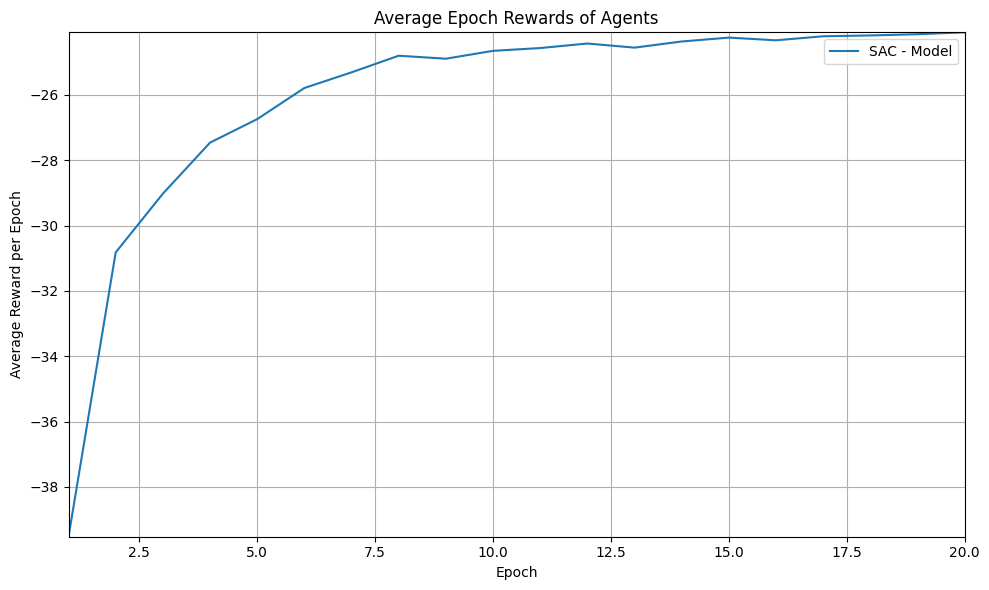

In [41]:
if train == True:
  plot_aer(
      {"SAC - Model": train_results['callback_rewards']},
      epochs = EPOCHS,
      episodes_per_epoch = int((train_summer_period_end - train_summer_period_start +1)/EPISODE_TIME_STEPS)
  )
else:
  plot_aer(
      {"SAC - Model": train_results['callback_relative']},
      epochs = EPOCHS,
      episodes_per_epoch = int((train_summer_period_end - train_summer_period_start +1)/EPISODE_TIME_STEPS)
  )

In [42]:
type(results)

for k, v in results.items():
  print(k)

NameError: name 'results' is not defined

In [71]:
for k,v in test_results.items():
  print(k)

test_results['steps']

actions
rewards
steps


743

#### Evaluation

######## BUILDING-LEVEL ########
Building-level KPIs:


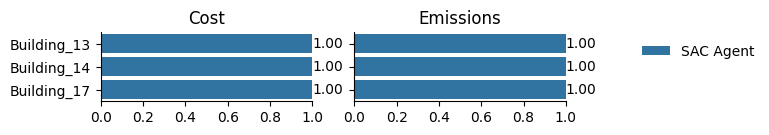

Building-level simulation period load profiles:


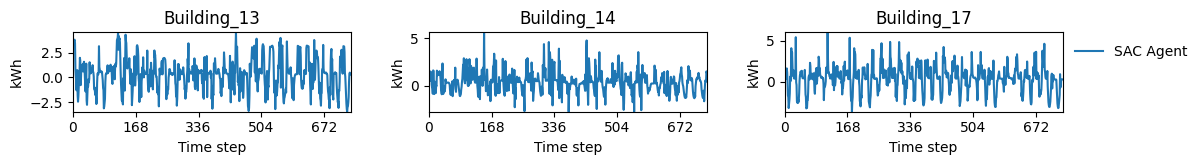

Building-level daily-average load profiles:


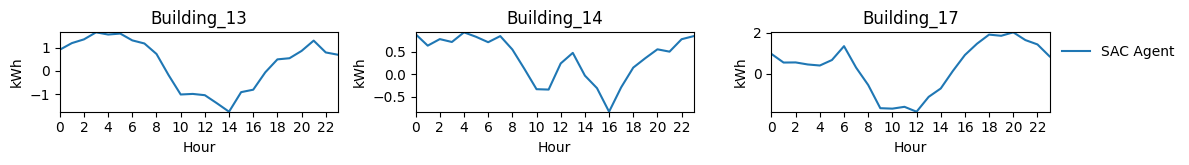

Battery SoC profiles:


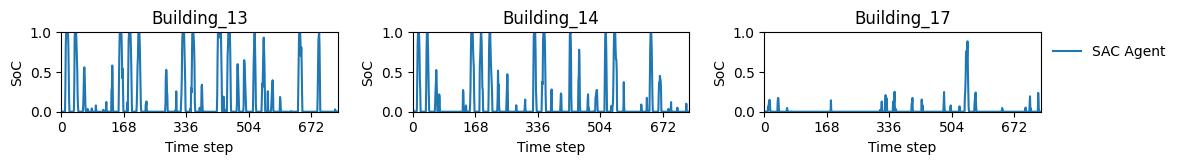

######## DISTRICT-LEVEL ########
District-level KPIs:


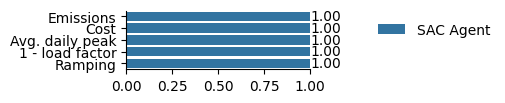

District-level simulation period load profiles:


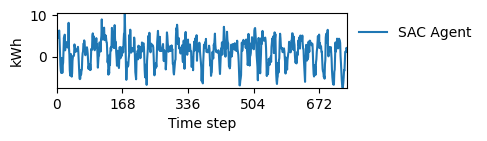

District-level daily-average load profiles:


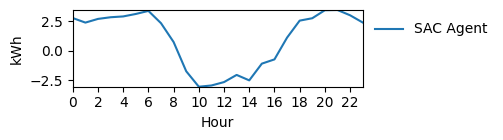

In [43]:

plot_simulation_summary({
    'SAC Agent': trainer_sac_baseline.test_env.unwrapped,
})

plt.show()


## Muli Agent Env

In [44]:
# Custom reward function adapted for the Multi Agent

class CustomReward_MA(RewardFunction):
    def __init__(self, env_metadata: dict[str, Any]):
        super().__init__(env_metadata)

    def calculate(self, observations: list[dict[str, int | float]]) -> list[float]:
        rewards = []

        for o in observations:
            cost = o["net_electricity_consumption"] * o["electricity_pricing"]
            battery_soc = o["electrical_storage_soc"]
            penalty = -(1.0 + np.sign(cost) * battery_soc)
            reward = penalty * abs(cost)
            rewards.append(reward)

        return rewards  # one value per building


In [45]:
# --- Env creation ---

train_env_ma= CityLearnEnv(
    TRAIN_DATASET,
    central_agent=False,
    buildings = BUILDINGS,
    reward_function=CustomReward_MA,
    simulation_start_time_step = train_summer_period_start,
    simulation_end_time_step = train_summer_period_end,
    episode_time_step = EPISODE_TIME_STEPS,
)

test_env_ma = CityLearnEnv(
    TEST_DATASET,
    centrale_agent = False,
    buildings = BUILDINGS_TEST,
    reward_function = CustomReward_MA,
    simulation_start_time_step = test_summer_start,
    simulation_end_time_step = test_summer_end,
)

In [74]:

test_env_ma = CityLearnEnv(
    TEST_DATASET,
    centrale_agent = False,
    buildings = BUILDINGS_TEST,
    reward_function = CustomReward_MA,
    simulation_start_time_step = test_summer_start,
    simulation_end_time_step = test_summer_end,
)

In [46]:
import numpy as np
from ray.rllib.env.multi_agent_env import MultiAgentEnv

class MultiAgentCityLearnWrapper(MultiAgentEnv):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.buildings = env.buildings
        self.num_buildings = len(self.buildings)

        # Agent IDs
        self.possible_agents = [f"building_{i}" for i in range(self.num_buildings)]
        self.agents = self.possible_agents.copy()

        # Single-agent spaces from CityLearn (homogeneous across buildings)
        single_obs_space = env.observation_space[0]
        single_act_space = env.action_space[0]

        # Plural spaces (required by RLlib new stack)
        self.observation_spaces = {
            aid: single_obs_space for aid in self.possible_agents
        }
        self.action_spaces = {
            aid: single_act_space for aid in self.possible_agents
        }

        # IMPORTANT: Make singular attributes dicts as well (not single Box),
        # so any fallback path in RLlib still sees per-agent mappings.
        self.observation_space = self.observation_spaces
        self.action_space = self.action_spaces

    def reset(self, *, seed=None, options=None):
        obs_list, _ = self.env.reset()
        self.agents = self.possible_agents.copy()

        obs = {
            aid: np.asarray(obs_list[i], dtype=np.float32)
            for i, aid in enumerate(self.possible_agents)
        }
        # Per-agent info dicts
        infos = {aid: {} for aid in self.possible_agents}
        return obs, infos

    def step(self, action_dict):
        # Convert actions to list in correct order
        actions = []
        for aid in self.possible_agents:
            if aid in action_dict:
                actions.append(np.asarray(action_dict[aid], dtype=np.float32))
            else:
                zero = np.zeros(self.action_spaces[aid].shape, dtype=np.float32)
                actions.append(zero)

        # Step through CityLearn
        obs_list, rewards_list, terminated, truncated, info = self.env.step(actions)

        # --- Defensive shape correction ---
        n = len(self.possible_agents)
        # Pad or trim observations
        if len(obs_list) < n:
            pad_obs = [np.zeros_like(self.observation_spaces[self.possible_agents[0]].sample())] * (n - len(obs_list))
            obs_list = list(obs_list) + pad_obs
        elif len(obs_list) > n:
            obs_list = obs_list[:n]

        # Pad or trim rewards
        if len(rewards_list) < n:
            pad_rew = [0.0] * (n - len(rewards_list))
            rewards_list = list(rewards_list) + pad_rew
        elif len(rewards_list) > n:
            rewards_list = rewards_list[:n]
        # ----------------------------------

        obs = {
            aid: np.asarray(obs_list[i], dtype=np.float32)
            for i, aid in enumerate(self.possible_agents)
        }
        rewards = {
            aid: float(rewards_list[i])
            for i, aid in enumerate(self.possible_agents)
        }

        terminateds = {aid: bool(terminated) for aid in self.possible_agents}
        truncateds = {aid: bool(truncated) for aid in self.possible_agents}
        infos = {aid: {} for aid in self.possible_agents}

        terminateds["__all__"] = bool(terminated)
        truncateds["__all__"] = bool(truncated)

        if terminated or truncated:
            self.agents = []

        return obs, rewards, terminateds, truncateds, infos

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()


In [47]:
wrapped = MultiAgentCityLearnWrapper(train_env_ma)
o, info = wrapped.reset()
print("obs keys:", list(o.keys()))
zero_actions = {aid: np.zeros(wrapped.action_spaces[aid].shape, dtype=np.float32) for aid in wrapped.possible_agents}
o2, r2, term2, trunc2, info2 = wrapped.step(zero_actions)
print("Step works. obs keys:", list(o2.keys()))
print("rewards:", r2)


obs keys: ['building_0', 'building_1', 'building_2']
Step works. obs keys: ['building_0', 'building_1', 'building_2']
rewards: {'building_0': -0.049056001007556915, 'building_1': -0.06481999903917313, 'building_2': -0.32804566621780396}


 ### PPO - MA Configuration

In [48]:
from ray.rllib.algorithms.ppo import PPOConfig
import ray
from ray.tune.registry import register_env

ray.shutdown()
ray.init(ignore_reinit_error=True, include_dashboard=False)

# Register wrapped environment
def env_creator(_):
    return MultiAgentCityLearnWrapper(train_env_ma)

register_env("CityLearnMultiAgent", env_creator)

# Get single-building spaces from the base env
single_obs_space = train_env_ma.observation_space[0]
single_act_space = train_env_ma.action_space[0]

#Compatible with Ray 2.49.2
config = (
    PPOConfig()
    .environment(env="CityLearnMultiAgent")
    .framework("torch")
    .env_runners(
        num_env_runners=1,       # how many parallel environments
        rollout_fragment_length="auto",
    )
    .training(
        lr=3e-4,
        gamma=0.99,
        entropy_coeff=0.01,
        vf_clip_param=10.0,
    )
    .multi_agent(
        policies={
            "shared_policy": (
                None,
                train_env_ma.observation_space[0],
                train_env_ma.action_space[0],
                {},
            )
        },
        policy_mapping_fn=lambda agent_id, episode, **kwargs: "shared_policy",
        policies_to_train=["shared_policy"],
    )
    .resources(num_gpus=1)
)


2025-10-10 12:26:50,456	INFO worker.py:1951 -- Started a local Ray instance.


In [49]:
import json
import numbers
import numpy as np
import torch

def make_json_safe(obj):
    """Recursively convert RLlib result objects to JSON-safe data."""
    # Handle dicts
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}

    # Handle lists/tuples
    elif isinstance(obj, (list, tuple)):
        return [make_json_safe(v) for v in obj]

    # Handle numpy scalars or arrays
    elif isinstance(obj, np.generic):
        return obj.item()  # convert np.float32, np.int64 -> Python scalar
    elif isinstance(obj, np.ndarray):
        return obj.tolist()

    # Handle torch tensors
    elif torch.is_tensor(obj):
        return obj.detach().cpu().tolist()

    # Handle primitive types
    elif isinstance(obj, (numbers.Number, str)) or obj is None:
        return obj

    # Fallback: string representation
    else:
        return str(obj)


### Traning Loop

In [50]:
from ray.rllib.algorithms.ppo import PPO
import pandas as pd
import os

algo = config.build_algo()

# === Base directory for all simulations ===
base_dir = '/content/drive/MyDrive/Università/2_Magistrale/RES/Thesis/06_simulations'

# === Create dated MA simulation folder ===
today = datetime.now().strftime("%Y_%m_%d")
ma_sim_dir = os.path.join(base_dir, f"MA_Simulations_{today}")

os.makedirs(ma_sim_dir, exist_ok=True)

# === Define save paths ===
results_path = os.path.join(ma_sim_dir, "training_results_full.json")
rewards_path = os.path.join(ma_sim_dir, "mean_rewards.json")

all_results = []
mean_rewards = []

start_time_ma = time.perf_counter()

for epoch in range(EPOCHS):
    r = algo.train()

    # Get mean return safely
    mean_reward = (
        r["env_runners"].get("episode_return_mean")
        or r.get("episode_reward_mean")
    )

    print(f"Epoch {epoch + 1}: mean reward = {mean_reward}")

    # Save everything
    all_results.append(r)
    mean_rewards.append(mean_reward)


elapsed_time_ma = time.perf_counter() - start_time_ma
print(f"Total training time: {elapsed_time_ma} seconds")

# Save results safely
safe_results = [make_json_safe(r) for r in all_results]

with open(results_path, "w") as f:
    json.dump(safe_results, f, indent=4)

with open(rewards_path, "w") as f:
    json.dump(mean_rewards, f, indent=4)


2025-10-10 12:27:00,944	WARNING algorithm_config.py:5045 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-10-10 12:27:00,981	INFO tensorboardx.py:45 -- pip install "ray[tune]" to see TensorBoard files.
2025-10-10 12:27:00,982	WARNING unified.py:56 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
(pid=5130) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=5130) E0000 00:00:1760099222.180525    5130 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5130) E0000 00:00:1760099222.187070    5130 cuda_blas.cc:1407] Unable to register c

Epoch 1: mean reward = -3634.3563484064402
Epoch 2: mean reward = -3595.3587248173717
Epoch 3: mean reward = -3613.7897967969
Epoch 4: mean reward = -3614.1978301385634
Epoch 5: mean reward = -3607.2517110445847
Epoch 6: mean reward = -3602.4041111712277
Epoch 7: mean reward = -3605.6907357115647
Epoch 8: mean reward = -3608.844305518975
Epoch 9: mean reward = -3614.8144293041823
Epoch 10: mean reward = -3619.173855149251
Epoch 11: mean reward = -3618.9434028744295
Epoch 12: mean reward = -3619.7537618610277
Epoch 13: mean reward = -3619.6837965040545
Epoch 14: mean reward = -3622.301760726701
Epoch 15: mean reward = -3624.307229048569
Epoch 16: mean reward = -3626.988782425587
Epoch 17: mean reward = -3630.6521174889335
Epoch 18: mean reward = -3637.5581935557784
Epoch 19: mean reward = -3641.7273146830553
Epoch 20: mean reward = -3646.688957880029
Total training time: 1133.1203049459998 seconds


In [64]:
print(EPOCHS)

20


In [51]:
for k,v in r.items():
  print(k)

print('/n ---')

for k,v in r['env_runners'].items():
  print(k)

timers
env_runners
learners
num_training_step_calls_per_iteration
num_env_steps_sampled_lifetime
fault_tolerance
env_runner_group
done
training_iteration
trial_id
date
timestamp
time_this_iter_s
time_total_s
pid
hostname
node_ip
config
time_since_restore
iterations_since_restore
perf
/n ---
module_to_env_connector
env_to_module_connector
num_env_steps_sampled
num_agent_steps_sampled
episode_len_min
env_reset_timer
sample
timers
agent_steps
env_to_module_sum_episodes_length_in
num_episodes_lifetime
num_module_steps_sampled_lifetime
num_agent_steps_sampled_lifetime
env_to_module_sum_episodes_length_out
episode_duration_sec_mean
agent_episode_returns_mean
module_episode_returns_mean
num_env_steps_sampled_lifetime
episode_len_mean
episode_return_min
rlmodule_inference_timer
num_episodes
num_module_steps_sampled
episode_return_mean
connector_pipeline_timer
episode_return_max
weights_seq_no
env_step_timer
episode_len_max
time_between_sampling
num_env_steps_sampled_lifetime_throughput


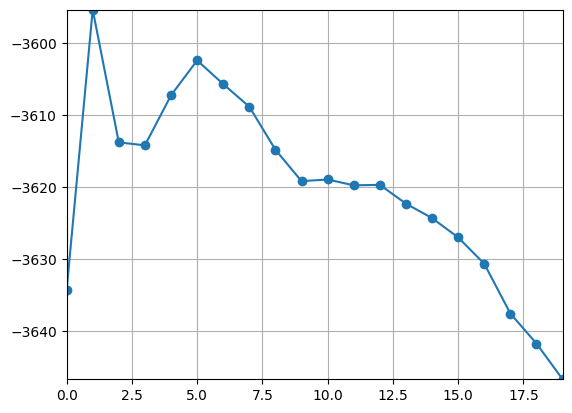

In [58]:
plt.plot(mean_rewards, marker='o')
plt.grid()

### Evaluation


In [75]:
import torch
import numpy as np
import pandas as pd
import torch.distributions as dist # Import distributions

# 1. Reset environment
obs, _ = test_env_ma.reset()
done = False
step_count = 0
# Assuming obs is a list of observations for each building
num_buildings = len(obs) # Get number of buildings from the length of obs
episode_rewards = np.zeros(num_buildings, dtype=np.float32)

print(f"Starting evaluation: {num_buildings} buildings")
action_log = []
# 2. Get the trained RLModule for your shared policy
module = algo.get_module("shared_policy")

# 3. Evaluation loop
while not done:
    step_count += 1
    actions = []

    # Compute actions for each building using forward_inference
    for i, o in enumerate(obs):
        # RLlib modules expect a dict with a batch of observations
        # Ensure observation is a torch tensor with correct dtype and shape
        input_dict = {"obs": torch.tensor(o, dtype=torch.float32).unsqueeze(0)} # Add batch dimension
        output = module.forward_inference(input_dict)

        # Get the action distribution inputs (mean and log_std for Normal distribution)
        action_dist_inputs = output["action_dist_inputs"].detach().cpu().numpy()[0]

        # Assuming action_dist_inputs are mean and log_std for Normal distribution
        # This might need adjustment based on the actual policy network output
        mean, log_std = action_dist_inputs[:1], action_dist_inputs[1:]
        std = np.exp(log_std)
        action = np.random.normal(mean, std, size=mean.shape) # Sample from the distribution

        # Ensure actions are within the environment's action space bounds if necessary
        # For SAC, actions are usually in [-1, 1] due to Tanh output
        action = np.tanh(action) # Assuming Tanh squashing is used
        actions.append(action)

    # Step the environment
    # Ensure actions passed to step is a list of actions for each agent
    obs, rewards, done, truncated, info = test_env_ma.step(actions)

    # Update episode rewards for each building
    episode_rewards += np.array(rewards, dtype=np.float32)

        # --- Log step data ---
    for i, action in enumerate(actions):
        action_log.append({
            "step": step_count,
            "building": i,
            "action": float(action[0]) if isinstance(action, np.ndarray) else float(action),
            "reward": float(rewards[i]),
        })

    # Check if done is a dictionary or a single boolean
    if isinstance(done, dict):
        done = done.get("__all__", False) # Use __all__ key for overall done status
    else:
        done = bool(done) # Assume it's a single boolean if not a dict

    if step_count % 24*10 == 0:
        print(f"Step {step_count}: Rewards = {rewards}, Done = {done}")


print(f"Evaluation finished after {step_count} steps")

# 4. Print total rewards per building
for i, r in enumerate(episode_rewards):
    print(f"Building {i}: total reward = {r:.3f}")

# 5. Compute KPIs
kpis = get_kpis(test_env_ma)
print("\nEvaluation KPIs:")
print(kpis)

# --- 6. Save action log ---
log_df = pd.DataFrame(action_log)
log_path = "evaluation_action_log.csv"
log_df.to_csv(log_path, index=False)
print(f"\nAction log saved to {log_path}")

Starting evaluation: 3 buildings
Step 24: Rewards = [np.float32(-0.07391616), np.float32(-0.5682795), np.float32(-1.971341)], Done = False
Step 48: Rewards = [np.float32(-0.16835855), np.float32(-0.04381224), np.float32(-1.8624712)], Done = False
Step 72: Rewards = [np.float32(-0.02321317), np.float32(-0.13726129), np.float32(-0.1376915)], Done = False
Step 96: Rewards = [np.float32(-0.30182946), np.float32(-0.038346358), np.float32(-0.78891295)], Done = False
Step 120: Rewards = [np.float32(-1.6439196), np.float32(-0.22069749), np.float32(-0.015391574)], Done = False
Step 144: Rewards = [np.float32(-0.44381943), np.float32(-0.8534492), np.float32(-0.14140484)], Done = False
Step 168: Rewards = [np.float32(-0.106652), np.float32(-0.8392551), np.float32(-0.9513298)], Done = False
Step 192: Rewards = [np.float32(-0.0775845), np.float32(-0.47240084), np.float32(-0.6664285)], Done = False
Step 216: Rewards = [np.float32(-0.26619533), np.float32(-0.0053902925), np.float32(-0.18999536)], Don

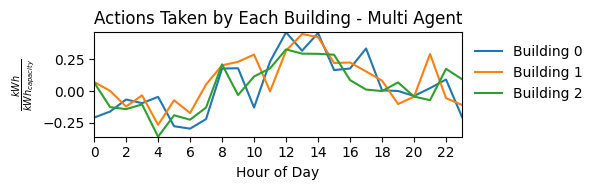

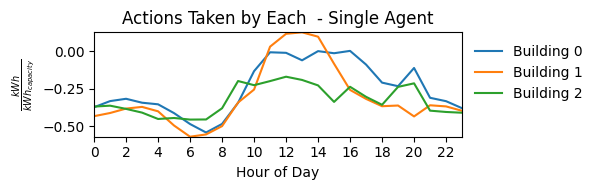

In [106]:
# Convert log to DataFrame if not already
log_df = pd.DataFrame(action_log)

# Pivot the DataFrame to get actions per time step (rows = step, columns = buildings)
pivot_df = log_df.pivot(index="step", columns="building", values="action").sort_index()

# Convert to list of lists
actions_list = pivot_df.values.tolist()

# Create building names
building_names = [f"Building {i}" for i in pivot_df.columns]

fig = plot_average_actions(
    actions_list=actions_list,
    building_names=building_names,
    title="Actions Taken by Each Building - Multi Agent",
    mode="daily_mean"
)
plt.show()

fig_two = plot_average_actions(
    actions_list = test_results['actions'],
    building_names = building_names,
    title = "Actions Taken by Each  - Single Agent",
    mode = "daily_mean"
)




In [98]:
building_names[0]

'Building 0'

In [80]:
type(building_names)

list

######## BUILDING-LEVEL ########
Building-level KPIs:


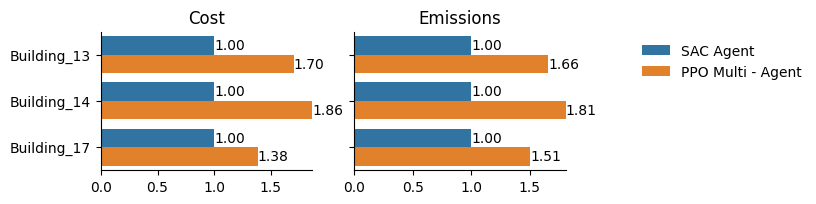

Building-level simulation period load profiles:


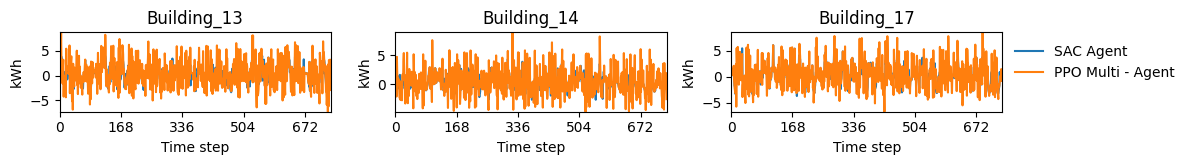

Building-level daily-average load profiles:


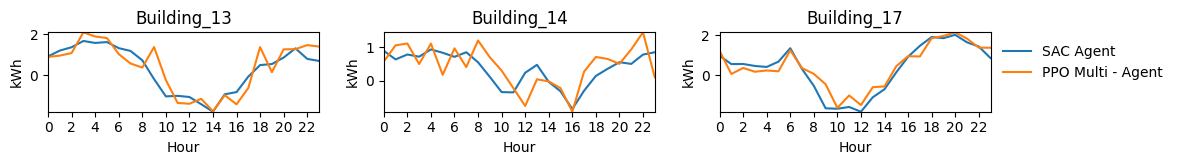

Battery SoC profiles:


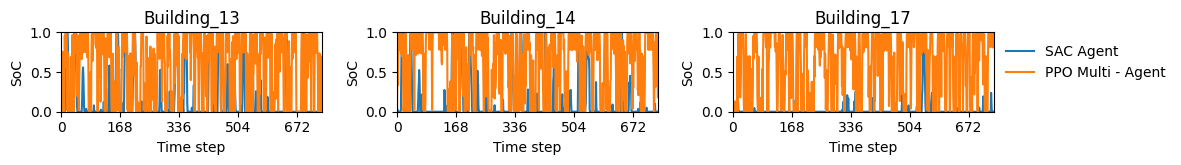

######## DISTRICT-LEVEL ########
District-level KPIs:


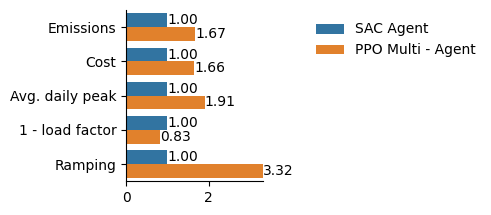

District-level simulation period load profiles:


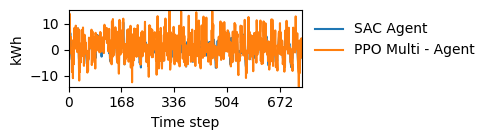

District-level daily-average load profiles:


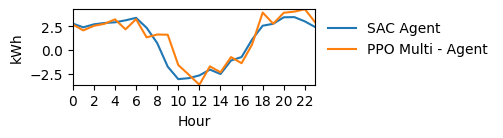

In [76]:
plot_simulation_summary({
    'SAC Agent': trainer_sac_baseline.test_env.unwrapped,
    'PPO Multi - Agent': test_env_ma,


})

plt.show()


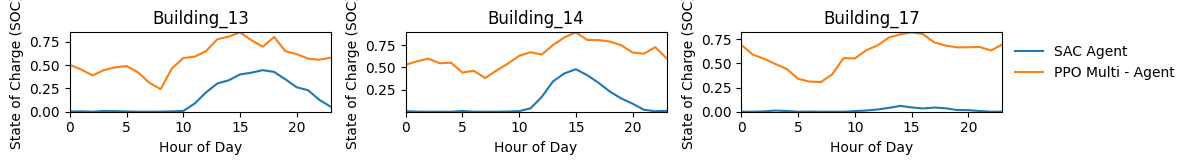

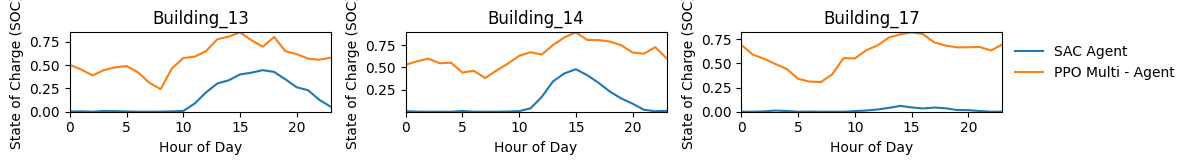

In [105]:
plot_average_soc_profiles(
    {'SAC Agent': trainer_sac_baseline.test_env.unwrapped,
    'PPO Multi - Agent': test_env_ma,
    },
    mode = 'daily'


)